# Co-acquisitions analyses

Make sure `prepare_coacquisition_files.py` was run before running this notebook. It can be run like this:
```bash
nohup python src/prepare_coacquisition_files.py  > prepare_coacquisition_files.log 2>&1 & disown
```

From `03-analyse-outputs/`, it can be run for all programs like this:
```bash
for i in ../data/compiled_results/*/; do basedir=$(basename $i);nohup ~/mambaforge/envs/hgt_analyses/bin/python src/prepare_coacquisition_files.py -p 200 -c $i > "../data/nohup_prepare_coacquisition_files_"$basedir".log" & disown ;done
```
This loops over all `compiled_results` subdirectories, and for each one, it runs the `prepare_coacquisition_files.py` script that results in the output in the same subdirectory for each program. The `-p` flag is the number of processes to use, and `-c` is the path to the subdirectory with compiled results for a single program. 

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# use plotly for interactive plots
import plotly.graph_objs as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator

plt.rcParams["font.family"] = "serif"


import json
# read in the marker styles
with open('lib/plot_marker_styles.json', 'r') as fh:
    marker_styles_dict = json.load(fh)['marker_styles_dict']
    # this is a dictionary such that for each method it contains 
    # a dict of marker styles for 'marker_pyplot', 'marker_plotly', 'marker_color', 'face_color', 'label'

In [2]:
res_dir = '../data/compiled_results/'
data_dir = '../data/'
plots_dir = '../plots/'


# the number of genes between a coacquired pair of genes, to be considered neighbors
neighbor_genes_between_cutoffs = [0, 1, 2, 3]
minimum_genome_size = 1000  # minimum genome size to consider a genome (i.e. contig or chromosome) for analysis
min_coacquisitions = 20 # minimum number of coacquisitions to consider a threshold of a method for analysis
# minimum number of coacquisitions with known positions, as a certain numerator, for considering it for percentage calculation
# e.g. for the percentage of coacquisitions that are neighbors, 
# we need at least this many neighbors that are coacquired for a given transfer threshold of a method to be considered
min_numerator = 0 # if 0, then in paper we add notes about the fact that there may be small number effects

In [3]:
import importlib
# reload the library in case it has been updated
if 'clsl' in globals():
    importlib.reload(clsl)
from lib import coacq_logscale_summary_lib as clsl


In [4]:
def prepare_coacquisition_summary_file(res_dir, neighbor_genes_between_cutoffs, minimum_genome_size, min_coacquisitions):
    # read in the data: chromosome locations, and coacquisitions for each method
    coacquisitions_dfs = clsl.load_data(res_dir)

    # for each method, find the minimum number of transfers under different transfer thresholds
    # between each pair of NOGs that are coacquired
    coacquisitions_dfs = clsl.calculate_min_transfers(coacquisitions_dfs)

    # summarize the number of coacquisitions by transfer threshold for each method
    coacquisitions_summary_df = clsl.summarize_coacquisitions_parallel(
        coacquisitions_dfs,
        neighbor_genes_between_cutoffs,
        minimum_genome_size,
        min_coacquisitions,
    )

    # replace zeros with NaNs for columns that should not have zeros
    coacquisitions_summary_df = clsl.replace_zeros_with_nan(
        coacquisitions_summary_df)
    # display the summary df in full
    display(coacquisitions_summary_df)
    return coacquisitions_summary_df

coacquisitions_summary_df = (
    prepare_coacquisition_summary_file(
        res_dir, neighbor_genes_between_cutoffs, minimum_genome_size,
        min_coacquisitions
    )
)

The following methods are included in the coacquisitions data:
['gloome.ml', 'gloome.ml.without_tree', 'angst', 'ale', 'ranger-fast', 'ranger', 'count.ml', 'wn']
Methods in the dataframe: ['gloome.ml' 'gloome.ml.without_tree' 'angst' 'ale' 'ranger-fast' 'ranger'
 'count.ml' 'wn']


method  coacquisitions with known positions  \
0   gloome.ml                                   76   
1   gloome.ml                                  100   
2   gloome.ml                                  200   
3   gloome.ml                                  500   
4   gloome.ml                                 1000   
..        ...                                  ...   
77   count.ml                               200000   
78   count.ml                               225839   
79   count.ml                               301112   
80   count.ml                               376386   
81         wn                               291381   

    neighbors (0 intervening genes)  \
0                               0.0   
1                               0.0   
2                               1.0   
3                               1.0   
4                              10.0   
..                              ...   
77                            785.0   
78                            829.0   
79                            986.0   
80                           1137.0   
81                            349.0   

    neighbor (max 0 intervening genes) percentage  \
0                                        0.000000   
1                                        0.000000   
2                                        0.500000   
3                                        0.200000   
4                                        1.000000   
..                                            ...   
77                                       0.392500   
78                                       0.367076   
79                                       0.327453   
80                                       0.302083   
81                                       0.119774   

    cotransfer and neighbor (max 0 intervening genes)  \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                                 NaN   
4                                                 NaN   
..                                                ...   
77                                                NaN   
78                                                NaN   
79                                                NaN   
80                                                NaN   
81                                                NaN   

    cotransfer and neighbor (max 0 intervening genes) percentage  \
0                                                 NaN              
1                                                 NaN              
2                                                 NaN              
3                                                 NaN              
4                                                 NaN              
..                                                ...              
77                                                NaN              
78                                                NaN              
79                                                NaN              
80                                                NaN              
81                                                NaN              

    expected percentage of neighboring coacquisitions (max 0 intervening genes)  \
0                                            0.069370                             
1                                            0.069475                             
2                                            0.067832                             
3                                            0.064918                             
4                                            0.059354                             
..                                                ...                             
77                                           0.066202                             
78                                           0.065598                             
79 

In [5]:
# for wn, we prepared the coacquisitions.wn.tsv file but the transfer thresholds correspond to discrete stringency levels
# so we need to convert the coacquisitions.wn.tsv file to a set of files, one for each stringency level
# each file will contain the coacquisitions for the corresponding stringency level
# the files will be named coacquisitions.wn.<stringency>.tsv
wn_coacquisitions_filepath = os.path.join(res_dir, 'wn',  'coacquisitions.wn.tsv')
wn_coacquisitions_df = pd.read_csv(wn_coacquisitions_filepath, sep='\t')
# the min of 'nog1_transfers' and 'nog2_transfers' is the stringency level
wn_coacquisitions_df['stringency'] = wn_coacquisitions_df[['nog1_transfers', 'nog2_transfers']].min(axis=1)
# keep only rows where gene positions are available
wn_coacquisitions_df = wn_coacquisitions_df[wn_coacquisitions_df['notes'] == 'gene_positions_are_available']
wn_dir = os.path.join(res_dir, 'wn')
os.makedirs(wn_dir, exist_ok=True)
for stringency in wn_coacquisitions_df['stringency'].unique():
    stringency_coacquisitions_df = wn_coacquisitions_df[wn_coacquisitions_df['stringency'] == stringency]
    stringency_coacquisitions_df.to_csv(os.path.join(wn_dir, f'coacquisitions.wn.{stringency}.tsv'), sep='\t', index=False)

###########################################################################################################################

methods_for_manual_thresholds = ['count_mp', 'gloome_mp', 'gloome_mp.without_tree', 'wn']
manual_threshold_coacquisitions_dfs = {}
for method in methods_for_manual_thresholds:
    # load the data
    manual_threshold_coacquisitions_dfs[method] = clsl.load_data(
        os.path.join(res_dir, method.split('.')[0]), include_manual_thresholds=True
    )
    # calculate the minimum number of transfers
    manual_threshold_coacquisitions_dfs[method] = clsl.calculate_min_transfers(
        manual_threshold_coacquisitions_dfs[method]
    )
    # summarize the coacquisitions
    manual_threshold_coacquisitions_dfs[method] = clsl.summarize_coacquisitions_manual_thresholds(
        manual_threshold_coacquisitions_dfs[method],
        neighbor_genes_between_cutoffs,
        minimum_genome_size,
        method=method.replace('_', '.', 1),
        min_coacquisitions=min_coacquisitions,
    )
    # replace zeros with NaNs
    manual_threshold_coacquisitions_dfs[method] = clsl.replace_zeros_with_nan(
        manual_threshold_coacquisitions_dfs[method]
    )
    # display the summary
    print(f'{method} coacquisitions summary:')
    display(manual_threshold_coacquisitions_dfs[method])

The following methods are included in the coacquisitions data:
['count.mp.0.33', 'count.mp.0.5', 'count.mp.1', 'count.mp.2', 'count.mp.3', 'count.mp.4', 'count.mp.5', 'count.mp.6', 'count.mp.7', 'count.mp.8']
Methods in the dataframe: ['count.mp']
count_mp coacquisitions summary:


method  coacquisitions with known positions  \
0  count.mp                                   65   
1  count.mp                                  190   
2  count.mp                                 1028   
3  count.mp                                 3055   
4  count.mp                                 8352   
5  count.mp                                34177   
6  count.mp                               139558   
7  count.mp                               515122   
8  count.mp                               770420   
9  count.mp                               887780   

   neighbors (0 intervening genes)  \
0                              1.0   
1                              7.0   
2                             29.0   
3                             57.0   
4                            112.0   
5                            272.0   
6                            636.0   
7                           1431.0   
8                           1832.0   
9                           1982.0   

   neighbor (max 0 intervening genes) percentage  \
0                                       1.538462   
1                                       3.684211   
2                                       2.821012   
3                                       1.865794   
4                                       1.340996   
5                                       0.795857   
6                                       0.455725   
7                                       0.277798   
8                                       0.237792   
9                                       0.223254   

   cotransfer and neighbor (max 0 intervening genes)  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   
5                                                NaN   
6                                                NaN   
7                                                NaN   
8                                                NaN   
9                                                NaN   

   cotransfer and neighbor (max 0 intervening genes) percentage  \
0                                                NaN              
1                                                NaN              
2                                                NaN              
3                                                NaN              
4                                                NaN              
5                                                NaN              
6                                                NaN              
7                                                NaN              
8                                                NaN              
9                                                NaN              

   expected percentage of neighboring coacquisitions (max 0 intervening genes)  \
0                                           0.058877                             
1                                           0.060176                             
2                                           0.056128                             
3                                           0.060182                             
4                                           0.061749                             
5                                           0.061482                             
6                                           0.063910                             
7                                           0.063131                             
8                                           0.062668                             
9                                           0.062238                             

   observed minus expected percentage of neighboring coacquisitions (max 0 intervening genes)  \
0                                           1.479584                                 

The following methods are included in the coacquisitions data:
['gloome.mp.0.33', 'gloome.mp.0.5', 'gloome.mp.1', 'gloome.mp.2', 'gloome.mp.3', 'gloome.mp.4', 'gloome.mp.5', 'gloome.mp.6', 'gloome.mp.7', 'gloome.mp.8', 'gloome.mp.without_tree.0.33', 'gloome.mp.without_tree.0.5', 'gloome.mp.without_tree.1', 'gloome.mp.without_tree.2', 'gloome.mp.without_tree.3', 'gloome.mp.without_tree.4', 'gloome.mp.without_tree.5', 'gloome.mp.without_tree.6', 'gloome.mp.without_tree.7', 'gloome.mp.without_tree.8']
Skipping non-numeric threshold value: without_tree.8
Skipping non-numeric threshold value: without_tree.7
Skipping non-numeric threshold value: without_tree.6
Skipping non-numeric threshold value: without_tree.5
Skipping non-numeric threshold value: without_tree.4
Skipping non-numeric threshold value: without_tree.3
Skipping non-numeric threshold value: without_tree.2
Skipping non-numeric threshold value: without_tree.1
Skipping non-numeric threshold value: without_tree.0.5
Skipping non-nume

method  coacquisitions with known positions  \
0  gloome.mp                                   65   
1  gloome.mp                                  190   
2  gloome.mp                                 1028   
3  gloome.mp                                 3055   
4  gloome.mp                                 8352   
5  gloome.mp                                34177   
6  gloome.mp                               139558   
7  gloome.mp                               515122   
8  gloome.mp                               770420   
9  gloome.mp                               887780   

   neighbors (0 intervening genes)  \
0                              1.0   
1                              7.0   
2                             29.0   
3                             57.0   
4                            112.0   
5                            272.0   
6                            636.0   
7                           1431.0   
8                           1832.0   
9                           1982.0   

   neighbor (max 0 intervening genes) percentage  \
0                                       1.538462   
1                                       3.684211   
2                                       2.821012   
3                                       1.865794   
4                                       1.340996   
5                                       0.795857   
6                                       0.455725   
7                                       0.277798   
8                                       0.237792   
9                                       0.223254   

   cotransfer and neighbor (max 0 intervening genes)  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   
5                                                NaN   
6                                                NaN   
7                                                NaN   
8                                                NaN   
9                                                NaN   

   cotransfer and neighbor (max 0 intervening genes) percentage  \
0                                                NaN              
1                                                NaN              
2                                                NaN              
3                                                NaN              
4                                                NaN              
5                                                NaN              
6                                                NaN              
7                                                NaN              
8                                                NaN              
9                                                NaN              

   expected percentage of neighboring coacquisitions (max 0 intervening genes)  \
0                                           0.058877                             
1                                           0.060176                             
2                                           0.056128                             
3                                           0.060182                             
4                                           0.061749                             
5                                           0.061482                             
6                                           0.063910                             
7                                           0.063131                             
8                                           0.062668                             
9                                           0.062238                             

   observed minus expected percentage of neighboring coacquisitions (max 0 intervening genes)  \
0                                           1.479584                       

The following methods are included in the coacquisitions data:
['gloome.mp.0.33', 'gloome.mp.0.5', 'gloome.mp.1', 'gloome.mp.2', 'gloome.mp.3', 'gloome.mp.4', 'gloome.mp.5', 'gloome.mp.6', 'gloome.mp.7', 'gloome.mp.8', 'gloome.mp.without_tree.0.33', 'gloome.mp.without_tree.0.5', 'gloome.mp.without_tree.1', 'gloome.mp.without_tree.2', 'gloome.mp.without_tree.3', 'gloome.mp.without_tree.4', 'gloome.mp.without_tree.5', 'gloome.mp.without_tree.6', 'gloome.mp.without_tree.7', 'gloome.mp.without_tree.8']
Skipping non-numeric threshold value: gloome.mp.8
Skipping non-numeric threshold value: gloome.mp.7
Skipping non-numeric threshold value: gloome.mp.6
Skipping non-numeric threshold value: gloome.mp.5
Skipping non-numeric threshold value: gloome.mp.4
Skipping non-numeric threshold value: gloome.mp.3
Skipping non-numeric threshold value: gloome.mp.2
Skipping non-numeric threshold value: gloome.mp.1
Skipping non-numeric threshold value: gloome.mp.0.5
Skipping non-numeric threshold value: gloome

method  coacquisitions with known positions  \
0  gloome.mp.without_tree                                 9955   
1  gloome.mp.without_tree                                13019   
2  gloome.mp.without_tree                                18467   
3  gloome.mp.without_tree                                27745   
4  gloome.mp.without_tree                                44737   
5  gloome.mp.without_tree                                80043   
6  gloome.mp.without_tree                               167423   
7  gloome.mp.without_tree                               531461   
8  gloome.mp.without_tree                               910400   
9  gloome.mp.without_tree                              1181447   

   neighbors (0 intervening genes)  \
0                             81.0   
1                            102.0   
2                            144.0   
3                            220.0   
4                            301.0   
5                            406.0   
6                            671.0   
7                           1386.0   
8                           2044.0   
9                           2366.0   

   neighbor (max 0 intervening genes) percentage  \
0                                       0.813661   
1                                       0.783470   
2                                       0.779769   
3                                       0.792936   
4                                       0.672821   
5                                       0.507227   
6                                       0.400781   
7                                       0.260791   
8                                       0.224517   
9                                       0.200263   

   cotransfer and neighbor (max 0 intervening genes)  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   
5                                                NaN   
6                                                NaN   
7                                                NaN   
8                                                NaN   
9                                                NaN   

   cotransfer and neighbor (max 0 intervening genes) percentage  \
0                                                NaN              
1                                                NaN              
2                                                NaN              
3                                                NaN              
4                                                NaN              
5                                                NaN              
6                                                NaN              
7                                                NaN              
8                                                NaN              
9                                                NaN              

   expected percentage of neighboring coacquisitions (max 0 intervening genes)  \
0                                           0.070220                             
1                                           0.068839                             
2                                           0.068105                             
3                                           0.067583                             
4                                           0.066633                             
5                                           0.065591                             
6                                           0.065288                             
7                                           0.065963                             
8                                           0.065957                             
9                                           0.066156                             

   observed minus expected percentage of n

The following methods are included in the coacquisitions data:
['wn', 'wn.4.0', 'wn.5.0', 'wn.7.0', 'wn.6.0', 'wn.13.0', 'wn.10.0', 'wn.8.0', 'wn.12.0', 'wn.11.0', 'wn.9.0']
Skipping non-numeric threshold value: wn
Methods in the dataframe: ['wn']
wn coacquisitions summary:


method  coacquisitions with known positions  \
0     wn                                   32   
1     wn                                   62   
2     wn                                   61   
3     wn                                  113   
4     wn                                  196   
5     wn                                  606   
6     wn                                 2356   
7     wn                                12608   
8     wn                                66304   
9     wn                               209043   

   neighbors (0 intervening genes)  \
0                              0.0   
1                              1.0   
2                              0.0   
3                              0.0   
4                              1.0   
5                              1.0   
6                              4.0   
7                             17.0   
8                             95.0   
9                            230.0   

   neighbor (max 0 intervening genes) percentage  \
0                                       0.000000   
1                                       1.612903   
2                                       0.000000   
3                                       0.000000   
4                                       0.510204   
5                                       0.165017   
6                                       0.169779   
7                                       0.134835   
8                                       0.143279   
9                                       0.110025   

   cotransfer and neighbor (max 0 intervening genes)  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   
5                                                NaN   
6                                                NaN   
7                                                NaN   
8                                                NaN   
9                                                NaN   

   cotransfer and neighbor (max 0 intervening genes) percentage  \
0                                                NaN              
1                                                NaN              
2                                                NaN              
3                                                NaN              
4                                                NaN              
5                                                NaN              
6                                                NaN              
7                                                NaN              
8                                                NaN              
9                                                NaN              

   expected percentage of neighboring coacquisitions (max 0 intervening genes)  \
0                                           0.060506                             
1                                           0.055362                             
2                                           0.078703                             
3                                           0.057572                             
4                                           0.067202                             
5                                           0.052509                             
6                                           0.057417                             
7                                           0.046601                             
8                                           0.055501                             
9                                           0.056146                             

   observed minus expected percentage of neighboring coacquisitions (max 0 intervening genes)  \
0                                          -0.060506                                            
1                 

In [6]:
# combine all these dataframes into one
# coacquisitions_summary_df = clsl.combine_coacquisitions_summary_records([coacquisitions_summary_df, wn_coacquisitions_summary_df])
# coacquisitions_summary_df = clsl.combine_coacquisitions_summary_records([coacquisitions_summary_df, count_mp_cq_summary_df])
for method in methods_for_manual_thresholds:
    coacquisitions_summary_df = clsl.combine_coacquisitions_summary_records(
        [coacquisitions_summary_df, manual_threshold_coacquisitions_dfs[method]] # type: ignore
    )
# drop duplicate rows
coacquisitions_summary_df = coacquisitions_summary_df.drop_duplicates() # type: ignore
display(coacquisitions_summary_df)
# sort the dataframe by method and 'coacquisitions with known positions'
coacquisitions_summary_df = coacquisitions_summary_df.sort_values(
    by=['method', 'coacquisitions with known positions'],
    ascending=[True, True]
)
# save the combined dataframe
coacquisitions_summary_df.to_csv(
    os.path.join(res_dir, "summary_coacquisitions_by_threshold_and_neighbors.tsv"),
    sep='\t', index=False
)

method  coacquisitions with known positions  \
0    gloome.ml                                   76   
1    gloome.ml                                  100   
2    gloome.ml                                  200   
3    gloome.ml                                  500   
4    gloome.ml                                 1000   
..         ...                                  ...   
117         wn                                  606   
118         wn                                 2356   
119         wn                                12608   
120         wn                                66304   
121         wn                               209043   

     neighbors (0 intervening genes)  \
0                                0.0   
1                                0.0   
2                                1.0   
3                                1.0   
4                               10.0   
..                               ...   
117                              1.0   
118                              4.0   
119                             17.0   
120                             95.0   
121                            230.0   

     neighbor (max 0 intervening genes) percentage  \
0                                         0.000000   
1                                         0.000000   
2                                         0.500000   
3                                         0.200000   
4                                         1.000000   
..                                             ...   
117                                       0.165017   
118                                       0.169779   
119                                       0.134835   
120                                       0.143279   
121                                       0.110025   

     cotransfer and neighbor (max 0 intervening genes)  \
0                                                  NaN   
1                                                  NaN   
2                                                  NaN   
3                                                  NaN   
4                                                  NaN   
..                                                 ...   
117                                                NaN   
118                                                NaN   
119                                                NaN   
120                                                NaN   
121                                                NaN   

     cotransfer and neighbor (max 0 intervening genes) percentage  \
0                                                  NaN              
1                                                  NaN              
2                                                  NaN              
3                                                  NaN              
4                                                  NaN              
..                                                 ...              
117                                                NaN              
118                                                NaN              
119                                                NaN              
120                                                NaN              
121                                                NaN              

     expected percentage of neighboring coacquisitions (max 0 intervening genes)  \
0                                             0.069370                             
1                                             0.069475                             
2                                             0.067832                             
3                                             0.064918                             
4                                             0.059354                             
..                                                 ...                             
117                                           0.052509                             
118                

In [7]:
coacquisitions_summary_df['method'].unique() # methods included

array(['ale', 'angst', 'count.ml', 'count.mp', 'gloome.ml',
       'gloome.ml.without_tree', 'gloome.mp', 'gloome.mp.without_tree',
       'ranger', 'ranger-fast', 'wn'], dtype=object)

Notes on the summary dataframe columns:
- **method**: the method used to infer HGT events and therefore coacquisitions
- **coacquisitions**: the number of coacquisitions for this method and threshold
- **threshold**: the threshold used to filter coacquisitions based on the minimum number of gene transfers between the two NOGs in the pair of genes being considered
- **neighbors (n intervening genes)**: the number of coacquisitions that are neighboring, where the number of intervening genes between the two genes in the pair is less than or equal to n
- **neighbor (n intervening genes) percentage**: the percentage of coacquisitions that are neighboring, based on neighboring coacquisitions **divided by the total number of coacquisitions with known positions**
- **cotransfer and neighbor (n intervening genes)**: the number of neighboring coacquisitions that also have cotransfers, i.e. gene transfers from the same source branch to the same recipient branch
- **cotransfer and neighbor (n intervening genes) percentage**: the percentage of neighboring coacquisitions that also have cotransfers, based on cotransfer and neighboring coacquisitions divided by the total number of coacquisitions with known positions
- **expected percentage of neighboring coacquisitions (n intervening genes)**: defined as 2*(t+1)*{# of coacquisitions for that chromosome} / {genome size of the chromosome}, where t is the max. number of intervening genes between the two genes in the pair
- **observed minus expected percentage of neighboring coacquisitions (n intervening genes)**: the difference between the observed percentage and expected percentage of neighboring coacquisitions
- **cotransfers**: the number of coacquisitions that have cotransfers, i.e. gene transfers from the same source branch to the same recipient branch
- **cotransfer percentage**: the percentage of coacquisitions that have cotransfers, based on cotransfers divided by the total number of coacquisitions with known positions

The expected percentage of neighboring coacquisitions is calculated as follows:
- For each horizontally transferred gene in a chromosome, the probability of another gene being transferred as a neighbor is `2*({max number of intervening genes}+1) / {genome size of the chromosome}` 
- The expected number of neighboring coacquisitions is then this probability multiplied by the number of coacquisitions for that chromosome.
- The expected _fraction_ of neighboring coacquisitions is sum of expected numbers of neighboring coacquisitions (per chromosome) divided by the sum of coacquisitions for all chromosomes.
- In other words, if $t$ is the max. number of intervening genes between the two genes in the pair (in our case t=1), and $n$ is the number of chromosomes among the inferred coacquisitions for a method, the expected percentage of neighboring coacquisitions is $$\frac{2\sum_{i=1}^{n} (t+1)(c_{i}/g_{i})}{\sum_{i=1}^{n} c_{i}}$$, 
where $c_{i}$ and $g_{i}$ are the number of coacquisitions and the genome size of chromosome $i$, respectively.
- Note that because of the dependence on the exact chromosomes that are present in the inferences for any given method, the expected percentage of neighboring coacquisitions can vary between methods, and across thresholds (i.e. number of coacquisitions) for the same method.


In [4]:
# read in the summary df
coacquisitions_summary_df = pd.read_csv(
    f"{res_dir}/summary_coacquisitions_by_threshold_and_neighbors.tsv", sep='\t')

In [5]:
# using plotly, plot each of the '*percentage' columns in the summary df against the threshold
# separate subplots for each percentage column, and separate lines for each method within each subplot
n_subplots = len(
    [col for col in coacquisitions_summary_df.columns if 'percentage' in col])
n_cols = 2
n_rows = int(np.ceil(n_subplots / n_cols))
side = 600

fig = make_subplots(
    rows=n_rows, cols=n_cols, subplot_titles=[
        col for col in coacquisitions_summary_df.columns if 'percentage' in col],
    vertical_spacing=0.03, horizontal_spacing=0.1)
for i, col in enumerate([col for col in coacquisitions_summary_df.columns if 'percentage' in col]):
    subplot_row = int(np.floor(i / n_cols) + 1)
    subplot_col = int(i % n_cols + 1)

    # showlegend = True if i == 0 else False
    for method in coacquisitions_summary_df['method'].unique():
        method_df = coacquisitions_summary_df[coacquisitions_summary_df['method'] == method].copy()

        # for any given method, the number of 'coacquisitions with known positions' is typically quite high
        # but depending on col, the y-axis percentage value can be quite low. 
        # We don't want to plot the points where the percentage is so low that relative to the number of coacquisitions the numerator is < min_numerator
        # so we filter out the rows where the numerator is < min_numerator
        method_df = method_df[method_df['coacquisitions with known positions'] * method_df[col]/100 > min_numerator]

        num_coacquisitions = method_df["coacquisitions with known positions"]
        percentage_col = method_df[col]
        # print(f"Plotting {method} for {col} with {num_coacquisitions} coacquisitions")
        # add a line for each method with markers. Add hover text with the method name and all column info for that method and threshold
        fig.add_trace(
            go.Scatter(
                x=num_coacquisitions,
                y=percentage_col,
                mode="lines+markers",
                name=marker_styles_dict[method]["label"],
                line=dict(color=marker_styles_dict[method]["marker_color"], width=2),
                marker=dict(
                    symbol=marker_styles_dict[method]["marker_plotly"],
                    size=10,
                    # marker_color and face_color based on marker_styles_dict
                    color=marker_styles_dict[method]["face_color"],
                    line=dict(
                        color=marker_styles_dict[method]["marker_color"], width=1
                    ),
                ),
                # the hover text is the method name, and all the columns for that method and threshold that have column name as col but without the percentage,
                # and all cols without 'percentage' in their name
                hovertext=method_df.apply(
                    lambda x: f"{method}<br>{'<br>'.join(
                # show only the columns that have the same name as col but without the percentage or ones that start with 'coacquisitions'
                [f'{k}: {v}' for k, v in x.to_dict().items() if (col.replace(' percentage', '') in k) or (k.startswith('coacquisitions')) or (k.startswith('transfer threshold'))])}",
                    axis=1,
                ),
                hoverinfo="text",
            ),
            row=subplot_row,
            col=subplot_col,
        )

    fig.update_xaxes(title_text='Co-acquisitions',
                     type='log', 
                     row=subplot_row, col=subplot_col)

    # set y axis title, but wrap it into two lines if it is too long
    if len(col.split(' ')) > 3:
        # groups of 3 words
        col_words = col.split(' ')
        col_words = [col_words[i:i+3] for i in range(0, len(col_words), 3)]
        col_words = [' '.join(words) for words in col_words]
        fig.update_yaxes(title_text='<br>'.join(col_words),
                         row=subplot_row, col=subplot_col)
    else:
        fig.update_yaxes(title_text=col, row=subplot_row, col=subplot_col)
    # remove subplot title
    fig.for_each_annotation(lambda a: a.update(text=''))
# set title
fig.update_layout(title_text="Percentage of coacquisitions with known positions, being neighbors, cotransfers, or both",
                    plot_bgcolor='white',
                    paper_bgcolor='white')
# dimensions for every subplot in figure are set to side by side
fig.update_layout(height=n_rows*side, width=n_cols*side)

# add gridlines both x and y
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray',
                    showline=True, linewidth=1, linecolor='black')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray',
                    showline=True, linewidth=1, linecolor='black')
# show
fig.show()

The following methods are included in the coacquisitions data:
['gloome.ml', 'gloome.ml.without_tree', 'angst', 'ale', 'ranger-fast', 'ranger', 'count.ml', 'wn']


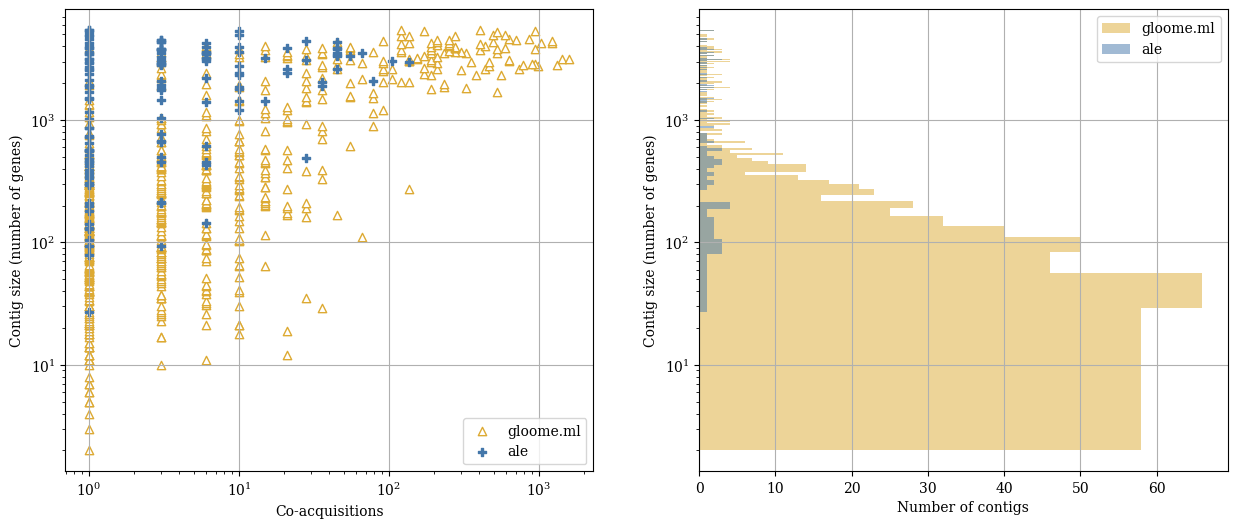

In [6]:
coacquisitions_dfs = clsl.load_data(res_dir)
# for each method, find the minimum number of transfers under different transfer thresholds
# between each pair of NOGs that are coacquired
coacquisitions_dfs = clsl.calculate_min_transfers(coacquisitions_dfs)

# we read in the coacquisitions of gloome.ml and ale. Plot the distributions of the genome_size of these two, in the same plot
# first group by the contig:genome_size, and count the number of coacquisitions for each, as a column 'coacquisitions'. Keep only the coacquisitions that have 'min_transfers' >= 0.8
min_transfer_threshold_for_coacquisitions = 0.8
num_bins = 200
gloome_ml_contigs = coacquisitions_dfs['gloome.ml'][coacquisitions_dfs['gloome.ml']['min_transfers'] >= min_transfer_threshold_for_coacquisitions].groupby(
    'contig:genome_size').size().to_frame()
ale_contigs = coacquisitions_dfs['ale'][coacquisitions_dfs['ale']['min_transfers'] >= min_transfer_threshold_for_coacquisitions].groupby(
    'contig:genome_size').size().to_frame()

# rename the column to 'coacquisitions'
gloome_ml_contigs = gloome_ml_contigs.rename(columns={0: 'coacquisitions'})
ale_contigs = ale_contigs.rename(columns={0: 'coacquisitions'})

# extract the genome size into a column, from the index
gloome_ml_contigs['genome_size'] = gloome_ml_contigs.index.str.split(':').str[1].astype(int)
ale_contigs['genome_size'] = ale_contigs.index.str.split(':').str[1].astype(int)

# 2d scatter plots for each method in the same figure, plotting the genome size of the contig against the number of coacquisitions
# 2 subplots, same row. One for scatter plot, one for histogram
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
for method in ['gloome.ml', 'ale']:
    method_df = gloome_ml_contigs if method == 'gloome.ml' else ale_contigs
    # sort by genome size
    method_df = method_df.sort_values('genome_size')

    x = method_df['coacquisitions']
    y = method_df['genome_size']

    # scatter plot
    axs[0].scatter(x, y, 
                label=method, marker=marker_styles_dict[method]['marker_pyplot'],
                color=marker_styles_dict[method]['marker_color'],
                facecolor=marker_styles_dict[method]['face_color'])

    # histogram, with y axis for genome size
    axs[1].hist(y, bins=num_bins, alpha=0.5, label=method, color=marker_styles_dict[method]['marker_color'], 
                orientation='horizontal')


axs[0].set_xlabel('Co-acquisitions')
axs[0].set_ylabel('Contig size (number of genes)')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].legend()
axs[0].grid(True)


axs[1].set_yscale('log')
axs[1].legend()
axs[1].set_xlabel('Number of contigs')
axs[1].set_ylabel('Contig size (number of genes)')
axs[1].grid(True)

plt.grid(True)
plt.show()
                  

# Plots for publication

In [7]:
# plt_style_file = 'lib/plot.mplstyle'
# plt.style.use(plt_style_file)
# mpl.rc_file(plt_style_file)

# Scale the relevant rcParams by 1.5x, but use font_scale_factor for font sizes
scale_factor = 1.5
font_scale_factor = 2.5
for key in mpl.rcParams:
    try:
        if not 'size' in key:
            continue
        # Use font_scale_factor if the key is related to font size
        if 'font' in key:
            factor = font_scale_factor
        else:
            factor = scale_factor
        if isinstance(mpl.rcParams[key], (int, float)) and not isinstance(mpl.rcParams[key], bool):
            mpl.rcParams[key] *= factor
        elif isinstance(mpl.rcParams[key], (list, tuple)):
            mpl.rcParams[key] = [v*factor if isinstance(v, (int, float)) and not isinstance(v, bool) else v for v in mpl.rcParams[key]]
    except Exception as e:
        print(f"Error scaling {key} from {mpl.rcParams[key]}: {e}")
        raise e

Following are plots with maximum 1 intervening genes between coacquired genes
x_data_lims: (62, 1181447)


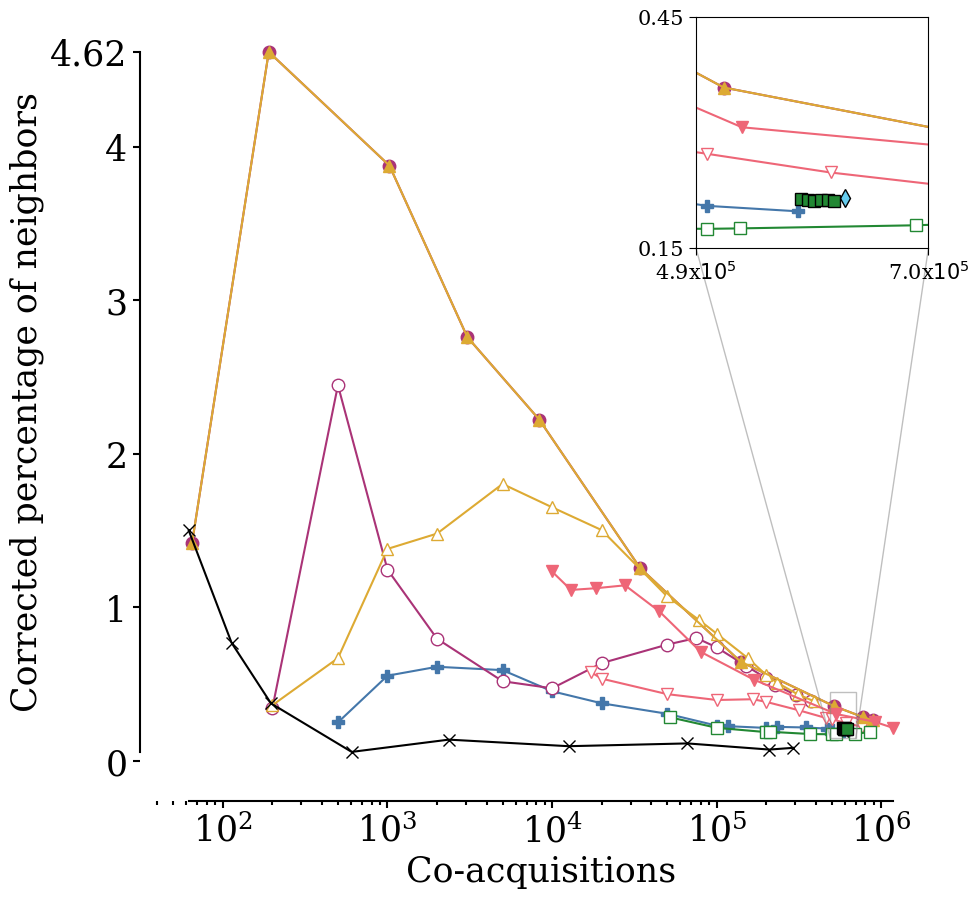

x_data_lims: (20, 848304)


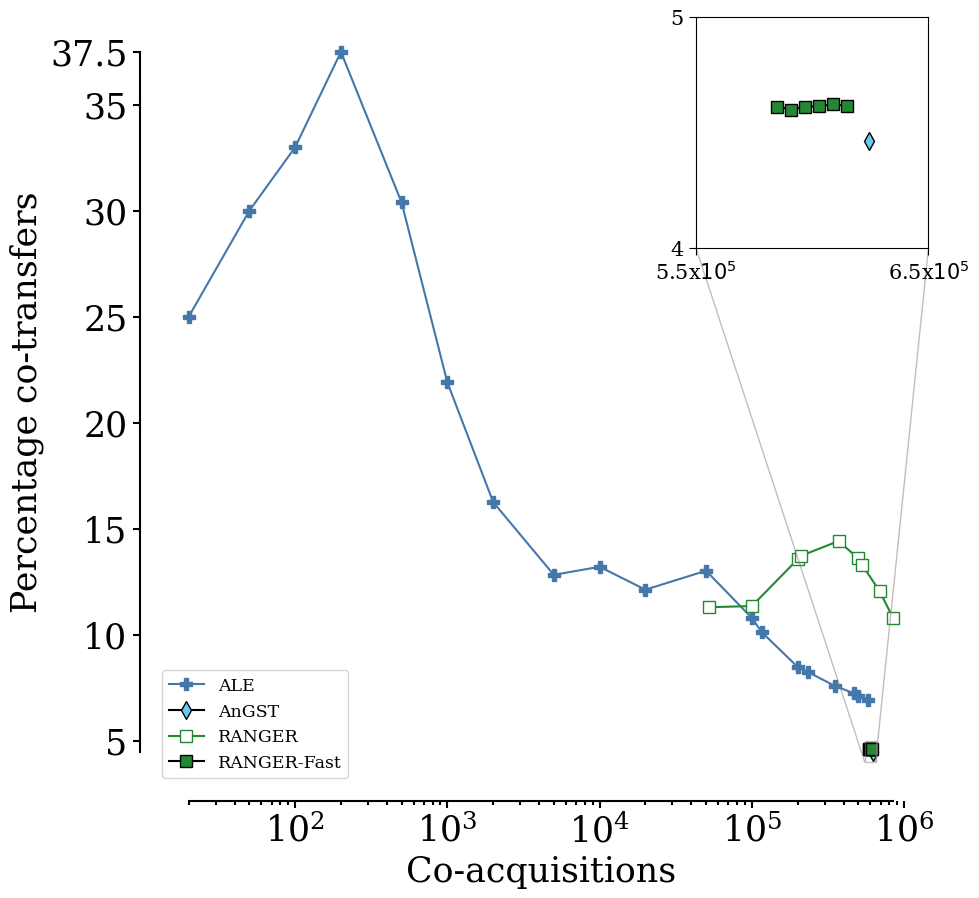

x_data_lims: (500, 848304)


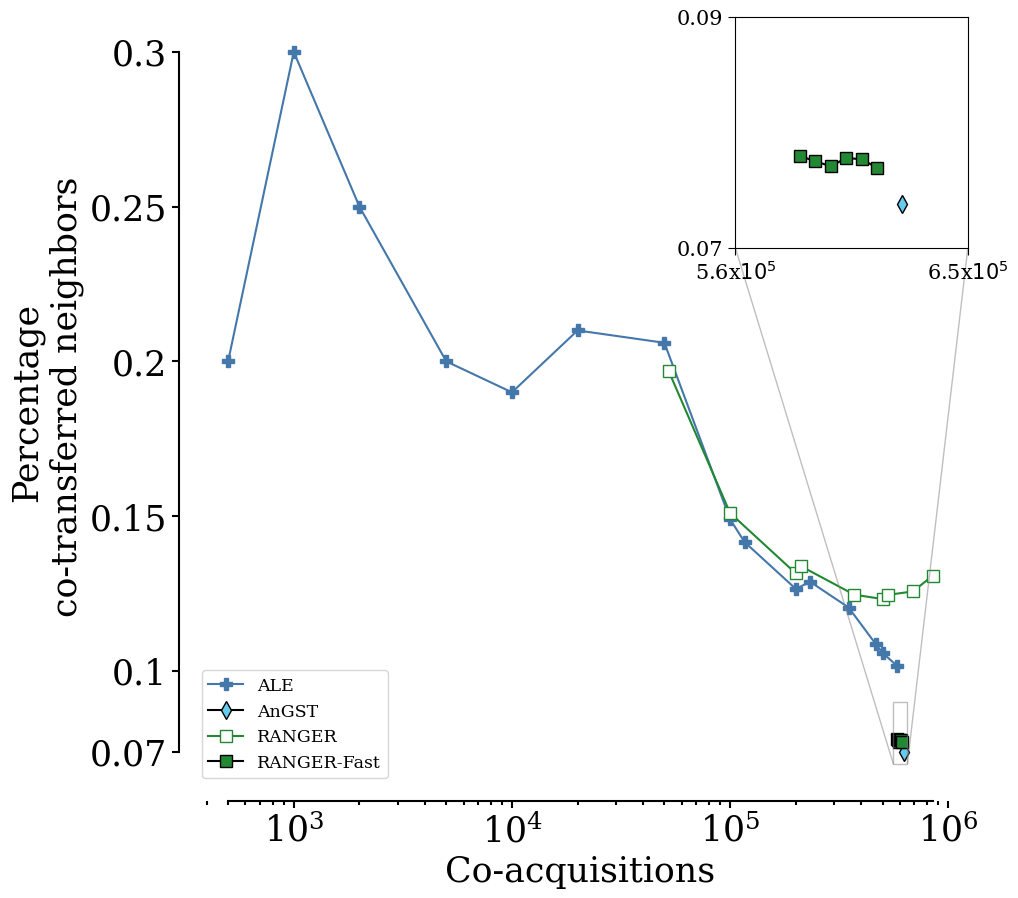

x_data_lims: (62, 1181447)


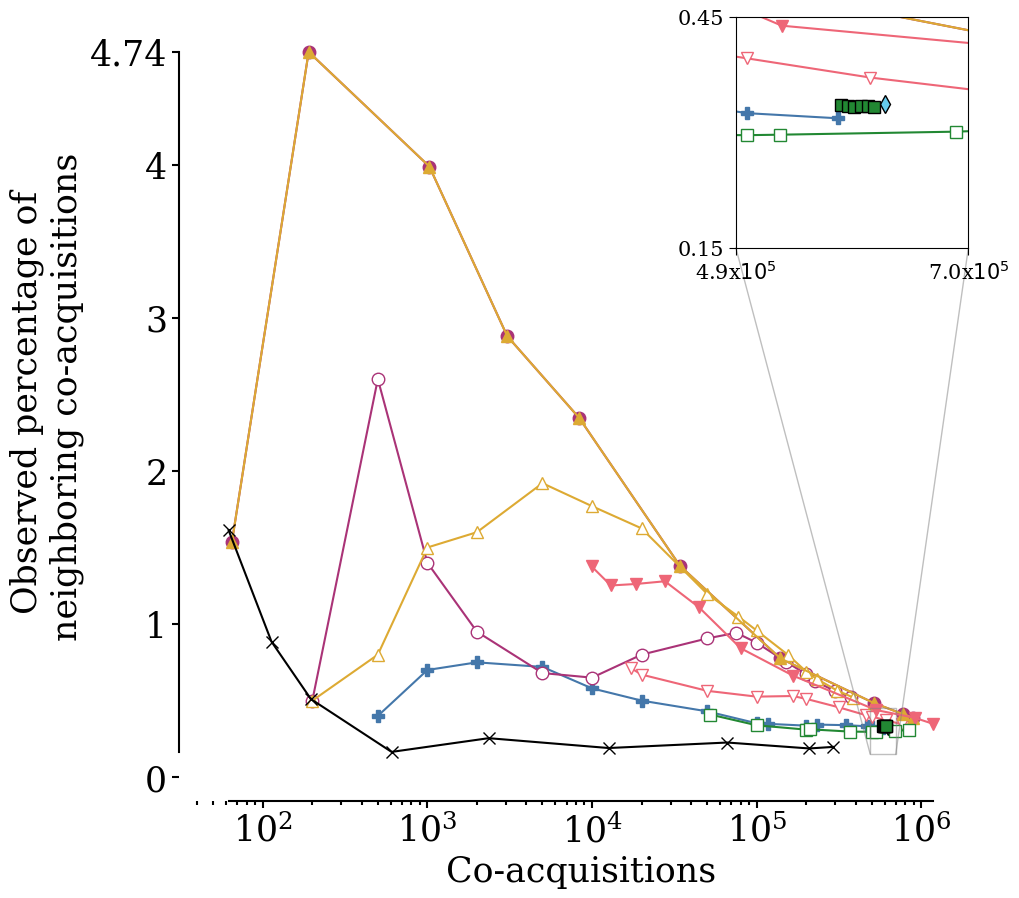

x_data_lims: (20, 1181447)


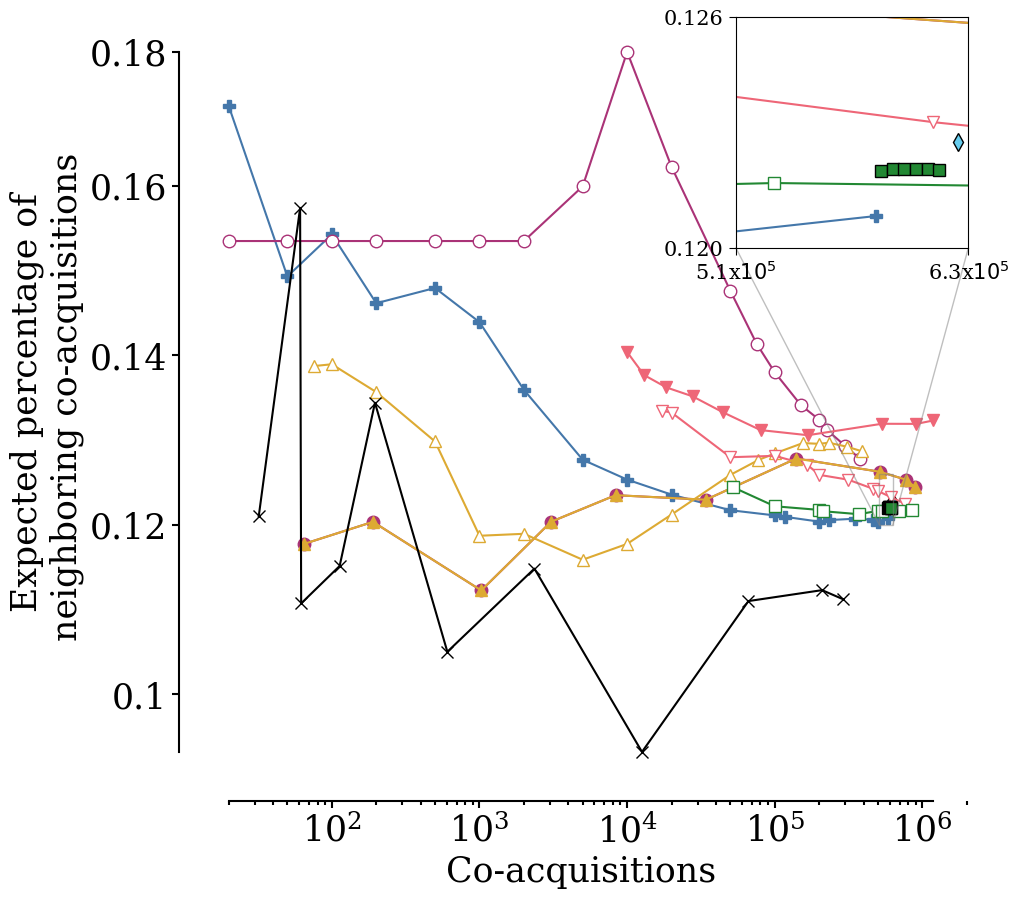

In [8]:

def plot_data_with_inset(ax, axins, data_df, x_col, y_col, marker_styles_dict, xlim, ylim, xlabel, ylabel, markersize_dict=None, legend=False):
    # loop over methods, and plot the data
    for method in data_df['method'].unique():
        method_df = data_df[data_df['method'] == method]
        # check if all values in method_df[y_col] are NaN or zero, if yes then skip plotting
        if method_df[y_col].isnull().all() or (method_df[y_col] == 0).all():
            continue
        # some of the percentage values are very low, so we filter out the rows where the absolute value of the numerator is < min_numerator
        method_df = method_df[method_df[x_col] * method_df[y_col]/100 > min_numerator]
        # plot the data
        # if markersize_dict is not None, then set the markersize_dict
        if markersize_dict is not None and method in markersize_dict:
            ax.plot(method_df[x_col], method_df[y_col],
                marker=marker_styles_dict[method]['marker_pyplot'], 
                color=marker_styles_dict[method]['marker_color'],
                markerfacecolor=marker_styles_dict[method]['face_color'],
                markersize=markersize_dict[method],
                label=marker_styles_dict[method]['label'])
        else:
            # plot the data with the default markersize
            ax.plot(method_df[x_col], method_df[y_col],
                # marker styles from marker_styles_dict
                marker=marker_styles_dict[method]['marker_pyplot'], 
                color=marker_styles_dict[method]['marker_color'],
                markerfacecolor=marker_styles_dict[method]['face_color'],
                label=marker_styles_dict[method]['label'])
        # now plot the same data in the inset
        if axins==None:
            continue
        axins.plot(method_df[x_col], method_df[y_col],
                   marker=marker_styles_dict[method]['marker_pyplot'],
                   color=marker_styles_dict[method]['marker_color'],
                   markerfacecolor=marker_styles_dict[method]['face_color'],
                     label=marker_styles_dict[method]['label'])
    # set labels and scales
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xscale('log')

    # Tufte style
    # remove the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # set the bottom and left spines to be thicker
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    # set the ticks to be thicker
    ax.tick_params(axis='both', which='major', width=1.5)
    ax.tick_params(axis='both', which='minor', width=1.5)
    # set spine limits to be the same as the data limits
    filtered_data_df = data_df[(data_df[x_col] * data_df[y_col] / 100 > min_numerator) & (data_df[y_col] > 0)]
    x_data_lims = filtered_data_df[x_col].min(), filtered_data_df[x_col].max()
    print(f"x_data_lims: {x_data_lims}")
    y_data_lims = filtered_data_df[y_col].min(), filtered_data_df[y_col].max()
    ax.spines['left'].set_bounds(y_data_lims[0], y_data_lims[1])
    ax.spines['bottom'].set_bounds(x_data_lims[0], x_data_lims[1])

    # add tick and tick label for the spine limits if they are not already there
    # get the tick locations
    x_ticks = ax.get_xticks()
    y_ticks = ax.get_yticks()
    # add the tick labels for the spine limits
    # add the tick labels for the y axis
    if y_data_lims[0] not in y_ticks:
        ax.yaxis.set_major_locator(FixedLocator(list(y_ticks) + [y_data_lims[0]]))
        ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
            lambda x, pos: f"{x:.2f}".rstrip('0').rstrip('.') if x % 1 != 0 else f"{int(x)}"))
    if y_data_lims[1] not in y_ticks:
        ax.yaxis.set_major_locator(FixedLocator(list(y_ticks) + [y_data_lims[1]]))
        ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
            lambda x, pos: f"{x:.2f}".rstrip('0').rstrip('.') if x % 1 != 0 else f"{int(x)}"))

    # let axes breathe by moving the spines away from the data
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))

    ax.grid(False)
    if axins==None:
        return ax, None

    axins.set_xlim(xlim)
    axins.set_ylim(ylim)
    # for inset, we want only the major ticks and in smaller font
    axins.tick_params(axis='both', which='major', labelsize=15)
    axins.tick_params(axis='both', which='minor', labelsize=15)
    axins.xaxis.set_major_locator(FixedLocator([xlim[0], xlim[1]]))
    axins.yaxis.set_major_locator(FixedLocator([ylim[0], ylim[1]]))
    axins.yaxis.set_minor_locator(FixedLocator([ylim[0], ylim[1]]))
    axins.xaxis.set_minor_locator(FixedLocator([xlim[0], xlim[1]]))
    # modify the labels to be in powers of 10
    axins.set_xticklabels([f"{x/1e5:.1f}x$10^5$" for x in [xlim[0], xlim[1]]])
    axins.grid(False)
    ax.indicate_inset_zoom(axins)

    if legend:
        ax.legend(
            # loc bottom left
            loc='lower left',
            fontsize=0.5 * mpl.rcParams['font.size']
        )

    return ax, axins


def save_and_show_plot(fig, filename):
    fig.savefig(filename, format='jpg', bbox_inches='tight', 
                # high dpi
                dpi=300)
    plt.show()


print("Following are plots with maximum 1 intervening genes between coacquired genes")

# Plot excess over random expectation percentage of neighboring coacquisitions
fig0, ax = plt.subplots(figsize=(10, 10))
axins = ax.inset_axes([0.7, 0.7, 0.3, 0.3])
ax, axins = plot_data_with_inset(ax, axins, coacquisitions_summary_df,
                        'coacquisitions with known positions', 'observed minus expected percentage of neighboring coacquisitions (max 1 intervening genes)',
                        marker_styles_dict, [4.9e5, 7e5], [0.15, 0.45],
                        'Co-acquisitions', 'Corrected percentage of neighbors')
save_and_show_plot(fig0, f"{plots_dir}/observed_minus_expected_percentage_of_neighboring_coacquisitions.jpg")

# Plot percentage cotransfers
fig1, ax = plt.subplots(figsize=(10, 10))
axins = ax.inset_axes([0.7, 0.7, 0.3, 0.3])
ax, axins = plot_data_with_inset(ax, axins, coacquisitions_summary_df,
                     'coacquisitions with known positions', 'cotransfer percentage',
                     marker_styles_dict, 
                     [5.5e5, 6.5e5], 
                     [4, 5],
                     'Co-acquisitions', 'Percentage co-transfers',
                        legend=True)
save_and_show_plot(fig1, f"{plots_dir}/percentage_cotransfers.jpg")

# Plot percentage cotransferred neighbors
fig2, ax = plt.subplots(figsize=(10, 10))
axins = ax.inset_axes([0.7, 0.7, 0.3, 0.3])
ax, axins = plot_data_with_inset(ax, axins, coacquisitions_summary_df,
                     'coacquisitions with known positions', 'cotransfer and neighbor (max 1 intervening genes) percentage',
                     marker_styles_dict, [5.6e5, 6.5e5], [0.07, 0.09],
                     'Co-acquisitions', 'Percentage\n co-transferred neighbors',
                        legend=True)
save_and_show_plot(fig2, f"{plots_dir}/percentage_cotransferred_neighbors.jpg")

# Plot observed percentage neighboring coacquisitions
fig3, ax1 = plt.subplots(figsize=(10, 10))
axins1 = ax1.inset_axes([0.7, 0.7, 0.3, 0.3])
ax, axins = plot_data_with_inset(ax1, axins1, coacquisitions_summary_df,
                     'coacquisitions with known positions', 'neighbor (max 1 intervening genes) percentage',
                     marker_styles_dict, [4.9e5, 7e5], [0.15, 0.45],
                     'Co-acquisitions', 'Observed percentage of\n neighboring co-acquisitions')
save_and_show_plot(
    fig3, f"{plots_dir}/observed_percentage_neighboring_coacquisitions.jpg")

# Plot expected percentage neighboring coacquisitions
fig4, ax2 = plt.subplots(figsize=(10, 10))
axins2 = ax2.inset_axes([0.7, 0.7, 0.3, 0.3])
ax, axins = plot_data_with_inset(ax2, axins2, coacquisitions_summary_df,
                     'coacquisitions with known positions', 'expected percentage of neighboring coacquisitions (max 1 intervening genes)',
                     marker_styles_dict, [5.1e5, 6.3e5], [0.12, 0.126],
                     'Co-acquisitions', 'Expected percentage of\n neighboring co-acquisitions')
save_and_show_plot(
    fig4, f"{plots_dir}/expected_percentage_neighboring_coacquisitions.jpg")

#

x_data_lims: (62, 887780)


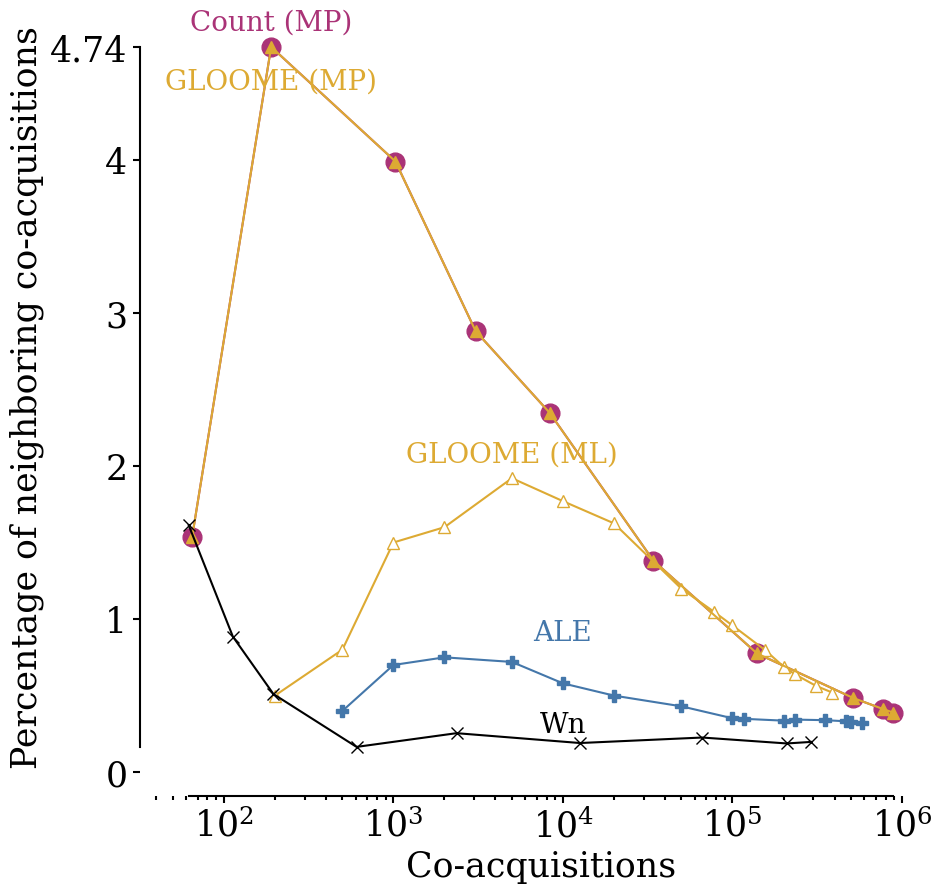

x_data_lims: (65, 1181447)


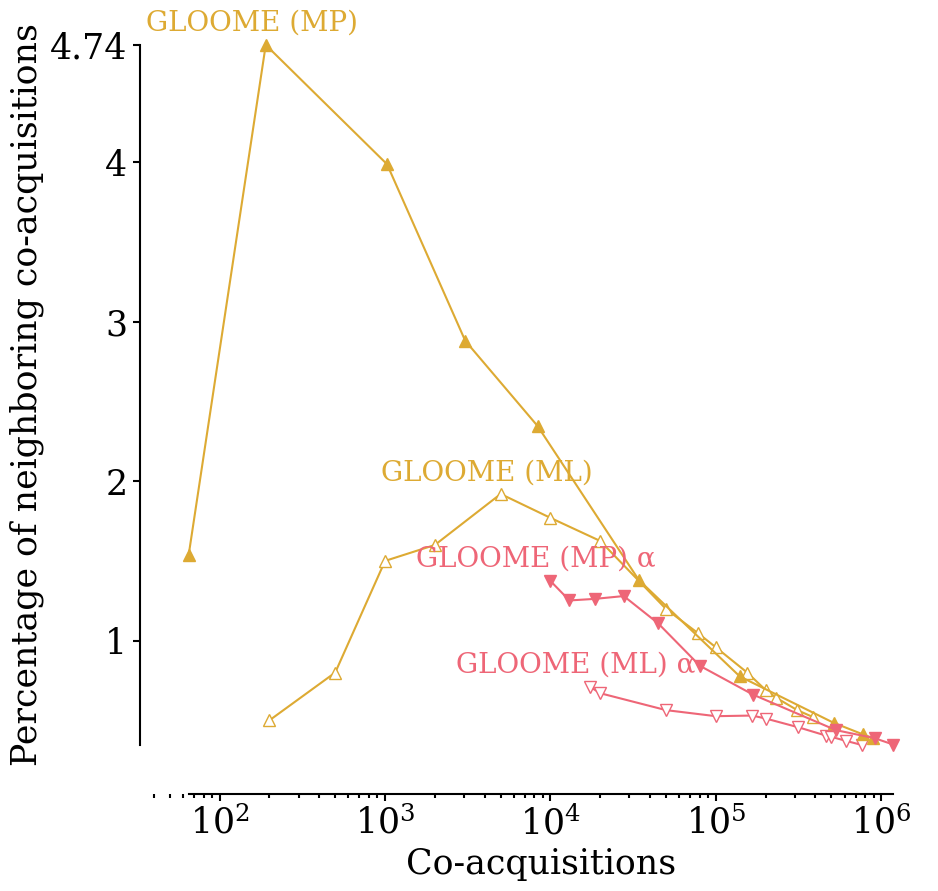

In [9]:
# plot a version of excess over random expectation percentage of neighboring coacquisitions
# but only for count.mp, gloome.ml, ale, wn

fig5, ax = plt.subplots(figsize=(10, 10))
# set font size for this figure
# plt.rcParams['font.size'] = plt.rcParams['axes.labelsize'] = plt.rcParams['axes.titlesize'] = 30
# axins = ax.inset_axes([0.7, 0.7, 0.3, 0.3])
to_plot_methods = ["count.mp", "gloome.ml", "gloome.mp", "ale", "wn"]
ax, axins = plot_data_with_inset(
    ax,
    None,
    coacquisitions_summary_df[
        coacquisitions_summary_df["method"].isin(to_plot_methods)
    ],
    "coacquisitions with known positions",
    "neighbor (max 1 intervening genes) percentage",
    marker_styles_dict,
    None,
    None,
    "Co-acquisitions", # x axis label
    "Percentage of neighboring co-acquisitions", # y axis label
    markersize_dict={'count.mp': 1.5*plt.rcParams['lines.markersize']},
)

# annotate the maximum point in each method with the method name (using the method label)
for method in to_plot_methods:
    method_df = coacquisitions_summary_df[
        coacquisitions_summary_df["method"] == method
    ]
    max_obs_minus_exp = method_df[
        method_df["neighbor (max 1 intervening genes) percentage"] == method_df["neighbor (max 1 intervening genes) percentage"].max()
    ]
    
    # find smallest x value on x axis in the figure
    min_x = ax.get_xlim()[0]
    # round this value up to nearest 10^5
    min_x = 10**np.ceil(np.log10(min_x))
    # same for y but max of y-axis
    min_y = ax.get_ylim()[1]
    # round it down to nearest 0.1
    min_y = np.floor(min_y*10)/10

    if method == "wn":
        min_y = 0.15
    if method == "ale" or method == "wn":
        min_x = 1e4
        

    ax.annotate(
        marker_styles_dict[method]['label'],
        (max(min_x, max_obs_minus_exp["coacquisitions with known positions"].values[0]),
            min(min_y, max_obs_minus_exp["neighbor (max 1 intervening genes) percentage"].values[0])),
        # offset the text to the right and up
        textcoords="offset points",
        xytext=(0, 12) if not method == 'gloome.mp' else (0, -30),  
        ha='center',
        # color based on marker_styles_dict
        color=marker_styles_dict[method]['marker_color'],
        # fontsize scaled by 0.8
        fontsize=0.8*plt.rcParams['font.size']
    )


save_and_show_plot(
    fig5,
    f"{plots_dir}/observed_percentage_of_neighboring_coacquisitions_subset.jpg",
)


# same as above but only gloome versions
fig6, ax = plt.subplots(figsize=(10, 10))
to_plot_methods = [
    "gloome.mp", "gloome.ml", "gloome.mp.without_tree", "gloome.ml.without_tree"
]
ax, axins = plot_data_with_inset(
    ax,
    None,
    coacquisitions_summary_df[
        coacquisitions_summary_df["method"].isin(to_plot_methods)
    ],
    "coacquisitions with known positions",
    "neighbor (max 1 intervening genes) percentage",
    marker_styles_dict,
    None,
    None,
    "Co-acquisitions", # x axis label
    "Percentage of neighboring co-acquisitions", # y axis label
)
for method in to_plot_methods:
    method_df = coacquisitions_summary_df[
        coacquisitions_summary_df["method"] == method
    ]
    max_obs_minus_exp = method_df[
        method_df["neighbor (max 1 intervening genes) percentage"] == method_df["neighbor (max 1 intervening genes) percentage"].max()
    ]
    
    # find smallest x value on x axis in the figure
    min_x = ax.get_xlim()[0]
    # round this value up to nearest 10^5
    min_x = 10**np.ceil(np.log10(min_x))
    # same for y but max of y-axis
    min_y = ax.get_ylim()[1]
    # round it down to nearest 0.1
    min_y = np.floor(min_y*10)/10

    if method == "wn":
        min_y = 0.15
    if method == "ale" or method == "wn":
        min_x = 1e4
        

    ax.annotate(
        marker_styles_dict[method]['label'],
        (max(min_x, max_obs_minus_exp["coacquisitions with known positions"].values[0]),
            min(min_y, max_obs_minus_exp["neighbor (max 1 intervening genes) percentage"].values[0])),
        # offset the text to the right and up
        textcoords="offset points",
        xytext=(-10, 10), # 5 points to the right and 5 points up
        ha='center',
        # color based on marker_styles_dict
        color=marker_styles_dict[method]['marker_color'],
        # fontsize scaled by 0.8
        fontsize=0.8*plt.rcParams['font.size']
    )

save_and_show_plot(
    fig6,
    f"{plots_dir}/observed_percentage_of_neighboring_coacquisitions_gloome_subset.jpg",
)

In [10]:
# group by method and calculate the mean and standard deviation of the percentage of neighboring coacquisitions, separately for different values of number of intervening genes

# create a dictionary to rename the methods
method_rename_dict = {k: marker_styles_dict[k]['label'] for k in coacquisitions_summary_df['method'].unique()}

# create a copy of this df, where we filter out the rows where the number neighbors is less than min_numerator
coacquisitions_summary_df_filtered = coacquisitions_summary_df[coacquisitions_summary_df['neighbors (1 intervening genes)'] > min_numerator].copy()
display(coacquisitions_summary_df_filtered[coacquisitions_summary_df_filtered['method'] == 'ale'])

all_mean_std_dfs = []
for num_intervening_genes in neighbor_genes_between_cutoffs:
    # group by method and calculate mean and std of the percentage of neighboring coacquisitions
    mean_std_df = coacquisitions_summary_df_filtered.groupby('method').agg(
        {f'neighbor (max {num_intervening_genes} intervening genes) percentage': ['mean', 'std', 'max']})
    mean_std_df.columns = mean_std_df.columns.droplevel(0)
    # sort by mean
    mean_std_df = mean_std_df.sort_values('mean', ascending=False)
    mean_std_df['std'] = mean_std_df['std'].fillna(0)
    mean_std_df = mean_std_df.rename(
        columns={
            "mean": f"Mean (t={num_intervening_genes})",
            "std": f"σ (t={num_intervening_genes})",
            "max": f"Max (t={num_intervening_genes})",
        }
    )
    mean_std_df.index = mean_std_df.index.map(method_rename_dict)

    # add this to the dictionary
    all_mean_std_dfs.append(mean_std_df)

# combine the mean, std, and max into a single df that is not multi-indexed
all_mean_std_df = pd.concat(all_mean_std_dfs, axis=1)

# print the tables as latex, with 3 decimal places. This is after concatenating the dataframes, except for the second one
print(pd.concat([df for i, df in enumerate(all_mean_std_dfs) if i != 1], axis=1).to_latex(float_format="%.3f").replace("σ", r"\textit{s}"))

# highlight the maximum value in each column in yellow
all_mean_std_df = all_mean_std_df.style.highlight_max(color='yellow', axis=0)
# highlight also in a different color the second maximum value in each column
all_mean_std_df = all_mean_std_df.apply(lambda x: ['background-color: lightyellow' if v == x.nlargest(2).iloc[1] else '' for v in x], axis=0)


print("Mean and standard deviation of the percentage of neighboring coacquisitions, \n\
      separately for different values of number of intervening genes (N) between coacquired genes.\n\
        Highlighted in yellow are the maximum values in each column, and in light yellow the second maximum values.")
display(all_mean_std_df)

# print the transfer threshold for each method, at which the maximum percentage of neighboring coacquisitions is observed
max_percentage_thresholds = coacquisitions_summary_df_filtered.groupby('method').apply(
    lambda x: [x['transfer threshold'][x['neighbor (max 1 intervening genes) percentage'].idxmax()], x['neighbor (max 1 intervening genes) percentage'].max()]
).to_dict()
max_percentage_thresholds = pd.DataFrame(max_percentage_thresholds, index=['transfer threshold', 'max corrected percentage neighboring coacquisitions']).T
max_percentage_thresholds.index = max_percentage_thresholds.index.map(method_rename_dict)
# sort by the maximum percentage of neighboring coacquisitions
max_percentage_thresholds = max_percentage_thresholds.sort_values('max corrected percentage neighboring coacquisitions', ascending=False)

print("Transfer threshold for each method, at which the maximum percentage of neighboring coacquisitions is observed:")
display(max_percentage_thresholds)

# table for t=1, with 3 decimal places, and replace sigma with the latex sigma, and print it for latex
# print(all_mean_std_dfs[0].to_latex(float_format="%.3f").replace("σ", r"$\sigma$"))
# combine with the table for transfer thresholds and print it for latex
t1_mean_std_df = all_mean_std_dfs[1]
t1_mean_std_df = t1_mean_std_df.join(max_percentage_thresholds['transfer threshold'])
display(t1_mean_std_df)
print(t1_mean_std_df.to_latex(float_format="%.3f").replace("σ", r"\textit{s}"))

method  coacquisitions with known positions  \
4     ale                                  500   
5     ale                                 1000   
6     ale                                 2000   
7     ale                                 5000   
8     ale                                10000   
9     ale                                20000   
10    ale                                50000   
11    ale                               100000   
12    ale                               116503   
13    ale                               200000   
14    ale                               232986   
15    ale                               349470   
16    ale                               465953   
17    ale                               500000   
18    ale                               582437   

    neighbors (0 intervening genes)  \
4                               2.0   
5                               6.0   
6                              12.0   
7                              28.0   
8                              41.0   
9                              66.0   
10                            126.0   
11                            205.0   
12                            236.0   
13                            389.0   
14                            477.0   
15                            699.0   
16                            890.0   
17                            929.0   
18                           1056.0   

    neighbor (max 0 intervening genes) percentage  \
4                                        0.400000   
5                                        0.600000   
6                                        0.600000   
7                                        0.560000   
8                                        0.410000   
9                                        0.330000   
10                                       0.252000   
11                                       0.205000   
12                                       0.202570   
13                                       0.194500   
14                                       0.204733   
15                                       0.200017   
16                                       0.191006   
17                                       0.185800   
18                                       0.181307   

    cotransfer and neighbor (max 0 intervening genes)  \
4                                                 1.0   
5                                                 3.0   
6                                                 5.0   
7                                                 9.0   
8                                                14.0   
9                                                27.0   
10                                               59.0   
11                                               91.0   
12                                              103.0   
13                                              158.0   
14                                              194.0   
15                                              267.0   
16                                              317.0   
17                                              331.0   
18                                              372.0   

    cotransfer and neighbor (max 0 intervening genes) percentage  \
4                                            0.200000              
5                                            0.300000              
6                                            0.250000              
7                                            0.180000              
8                                            0.140000              
9                                            0.135000              
10                                           0.118000              
11                                           0.091000              
12                                           0.088410              
13                                           0.079000              
14                                           0.083267              

\begin{tabular}{lrrrrrrrrr}
\toprule
 & Mean (t=0) & \textit{s} (t=0) & Max (t=0) & Mean (t=2) & \textit{s} (t=2) & Max (t=2) & Mean (t=3) & \textit{s} (t=3) & Max (t=3) \\
method &  &  &  &  &  &  &  &  &  \\
\midrule
Count (MP) & 1.324 & 1.187 & 3.684 & 2.198 & 1.666 & 4.737 & 2.396 & 1.716 & 4.961 \\
GLOOME (MP) & 1.324 & 1.187 & 3.684 & 2.198 & 1.666 & 4.737 & 2.396 & 1.716 & 4.961 \\
GLOOME (ML) & 0.657 & 0.335 & 1.180 & 1.347 & 0.593 & 2.380 & 1.547 & 0.692 & 2.840 \\
GLOOME (MP) α & 0.544 & 0.255 & 0.814 & 1.192 & 0.549 & 1.888 & 1.410 & 0.640 & 2.250 \\
Count (ML) & 0.460 & 0.256 & 1.200 & 1.124 & 0.641 & 3.200 & 1.355 & 0.739 & 3.800 \\
Wn & 0.330 & 0.501 & 1.613 & 0.573 & 0.493 & 1.613 & 0.654 & 0.447 & 1.613 \\
ALE & 0.314 & 0.160 & 0.600 & 0.578 & 0.165 & 0.880 & 0.672 & 0.170 & 1.020 \\
GLOOME (ML) α & 0.289 & 0.065 & 0.405 & 0.672 & 0.171 & 0.995 & 0.817 & 0.212 & 1.232 \\
AnGST & 0.196 & 0.000 & 0.196 & 0.454 & 0.000 & 0.454 & 0.561 & 0.000 & 0.561 \\
RANGER-Fast & 0.194

Transfer threshold for each method, at which the maximum percentage of neighboring coacquisitions is observed:


/tmp/ipykernel_1069953/288018447.py:49: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



transfer threshold  \
Count (MP)                7.00000   
GLOOME (MP)               7.00000   
Count (ML)                0.99998   
GLOOME (ML)               0.95620   
Wn                       13.00000   
GLOOME (MP) α             8.00000   
ALE                       0.77000   
GLOOME (ML) α             1.00000   
RANGER                    1.00000   
AnGST                     1.00000   
RANGER-Fast               1.00000   

               max corrected percentage neighboring coacquisitions  
Count (MP)                                              4.736842    
GLOOME (MP)                                             4.736842    
Count (ML)                                              2.600000    
GLOOME (ML)                                             1.920000    
Wn                                                      1.612903    
GLOOME (MP) α                                           1.376193    
ALE                                                     0.750000    
GLOOME (ML) α                                           0.711312    
RANGER                                                  0.408998    
AnGST                                                   0.337033    
RANGER-Fast                                             0.335648

Mean (t=1)   σ (t=1)  Max (t=1)  transfer threshold
method                                                            
Count (MP)       1.893386  1.553917   4.736842             7.00000
GLOOME (MP)      1.893386  1.553917   4.736842             7.00000
GLOOME (ML)      1.075609  0.490852   1.920000             0.95620
Count (ML)       0.896233  0.523120   2.600000             0.99998
GLOOME (MP) α    0.895689  0.409391   1.376193             8.00000
GLOOME (ML) α    0.498833  0.118945   0.711312             1.00000
Wn               0.469948  0.488747   1.612903            13.00000
ALE              0.451718  0.158290   0.750000             0.77000
AnGST            0.337033  0.000000   0.337033             1.00000
RANGER-Fast      0.334114  0.000921   0.335648             1.00000
RANGER           0.319126  0.036210   0.408998             1.00000

\begin{tabular}{lrrrr}
\toprule
 & Mean (t=1) & \textit{s} (t=1) & Max (t=1) & transfer threshold \\
method &  &  &  &  \\
\midrule
Count (MP) & 1.893 & 1.554 & 4.737 & 7.000 \\
GLOOME (MP) & 1.893 & 1.554 & 4.737 & 7.000 \\
GLOOME (ML) & 1.076 & 0.491 & 1.920 & 0.956 \\
Count (ML) & 0.896 & 0.523 & 2.600 & 1.000 \\
GLOOME (MP) α & 0.896 & 0.409 & 1.376 & 8.000 \\
GLOOME (ML) α & 0.499 & 0.119 & 0.711 & 1.000 \\
Wn & 0.470 & 0.489 & 1.613 & 13.000 \\
ALE & 0.452 & 0.158 & 0.750 & 0.770 \\
AnGST & 0.337 & 0.000 & 0.337 & 1.000 \\
RANGER-Fast & 0.334 & 0.001 & 0.336 & 1.000 \\
RANGER & 0.319 & 0.036 & 0.409 & 1.000 \\
\bottomrule
\end{tabular}



# Distribution of distances between coacquisitions


In [11]:
# for number of coacquisitions (with known positions) being 1e3, 1e4, 1e5,
# plot the observed distributions of distances between coacquired genes

automatic_stringency_coacq_dfs = clsl.load_data(res_dir, include_manual_thresholds=False)


The following methods are included in the coacquisitions data:
['gloome.ml', 'gloome.ml.without_tree', 'angst', 'ale', 'ranger-fast', 'ranger', 'count.ml', 'wn']


In [12]:
# based on the neighboring coacquisitions analysis above,
# we set the stringency levels for the different methods
# to see the distributions of distances between coacquired genes
manual_stringency_dict = {
    # method: stringency level for [1e3, 1e4, 1e5]
    'wn': [7, 6, 4],
    'count_mp': [6, 4, 2],
    'gloome_mp': [6, 4, 2],
    'gloome_mp.without_tree': [8, 8, 4],
}
# for each of the methods where we manually set the stringency,
## we read in only the corresponding coacquisition file based on this dictionary above

manual_threshold_coacq_dfs = {}
for method, stringency_levels in manual_stringency_dict.items():
    # read in the coacquisitions for this method
    coacq_dfs = clsl.load_data(
        os.path.join(res_dir, method.split('.')[0]),
        include_manual_thresholds=True
    )
    # add min_transfers column
    coacq_dfs = clsl.calculate_min_transfers(coacq_dfs)
    # keep only the dfs for stringency levels as defined in the dictionary
    keys_to_delete = []
    method_name = method.replace('_', '.', 1)
    for method_stringency in list(coacq_dfs.keys()):
        try:
            stringency = float(method_stringency.replace(f'{method_name}.', ''))
        except ValueError:
            # if the stringency level is not a float, then it is not a stringency level
            keys_to_delete.append(method_stringency)
            continue
        # check if the stringency level is in the list of stringency levels for this method
        if stringency not in stringency_levels:
            keys_to_delete.append(method_stringency)
    print(f"Keys to delete: {keys_to_delete}")
    for k in keys_to_delete:
        del coacq_dfs[k]
    manual_threshold_coacq_dfs[method_name] = {}
    for k, df in coacq_dfs.items():
        # find the stringency level for this df
        stringency = float(k.replace(f'{method_name}.', ''))
        manual_threshold_coacq_dfs[method_name][stringency] = df

The following methods are included in the coacquisitions data:
['wn', 'wn.4.0', 'wn.5.0', 'wn.7.0', 'wn.6.0', 'wn.13.0', 'wn.10.0', 'wn.8.0', 'wn.12.0', 'wn.11.0', 'wn.9.0']
Keys to delete: ['wn', 'wn.5.0', 'wn.13.0', 'wn.10.0', 'wn.8.0', 'wn.12.0', 'wn.11.0', 'wn.9.0']
The following methods are included in the coacquisitions data:
['count.mp.0.33', 'count.mp.0.5', 'count.mp.1', 'count.mp.2', 'count.mp.3', 'count.mp.4', 'count.mp.5', 'count.mp.6', 'count.mp.7', 'count.mp.8']
Keys to delete: ['count.mp.0.33', 'count.mp.0.5', 'count.mp.1', 'count.mp.3', 'count.mp.5', 'count.mp.7', 'count.mp.8']
The following methods are included in the coacquisitions data:
['gloome.mp.0.33', 'gloome.mp.0.5', 'gloome.mp.1', 'gloome.mp.2', 'gloome.mp.3', 'gloome.mp.4', 'gloome.mp.5', 'gloome.mp.6', 'gloome.mp.7', 'gloome.mp.8', 'gloome.mp.without_tree.0.33', 'gloome.mp.without_tree.0.5', 'gloome.mp.without_tree.1', 'gloome.mp.without_tree.2', 'gloome.mp.without_tree.3', 'gloome.mp.without_tree.4', 'gloome.

In [13]:
# print keys of both levels of the dictionary
for method, stringency_dfs in manual_threshold_coacq_dfs.items():
    print(f"Method: {method}, stringency_dfs keys: {stringency_dfs.keys()}")


Method: wn, stringency_dfs keys: dict_keys([4.0, 7.0, 6.0])
Method: count.mp, stringency_dfs keys: dict_keys([2.0, 4.0, 6.0])
Method: gloome.mp, stringency_dfs keys: dict_keys([2.0, 4.0, 6.0])
Method: gloome.mp.without_tree, stringency_dfs keys: dict_keys([4.0, 8.0])


Method: ale, num_coacq: 1000.0, first bin y: 0.8
Method: angst, num_coacq: 1000.0, first bin y: 0.2
Method: count.ml, num_coacq: 1000.0, first bin y: 2.0
Method: gloome.ml, num_coacq: 1000.0, first bin y: 3.5999999999999996
Method: gloome.ml.without_tree, num_coacq: 1000.0, first bin y: 1.4000000000000001
Method: ranger, num_coacq: 1000.0, first bin y: 0.2
Method: ranger-fast, num_coacq: 1000.0, first bin y: 0.1
Method: count.mp, num_coacq: 1000.0, first bin y: 5.0
Method: gloome.mp, num_coacq: 1000.0, first bin y: 5.3
Method: gloome.mp.without_tree, num_coacq: 1000.0, first bin y: 0.2
Method: wn, num_coacq: 1000.0, first bin y: 0.2


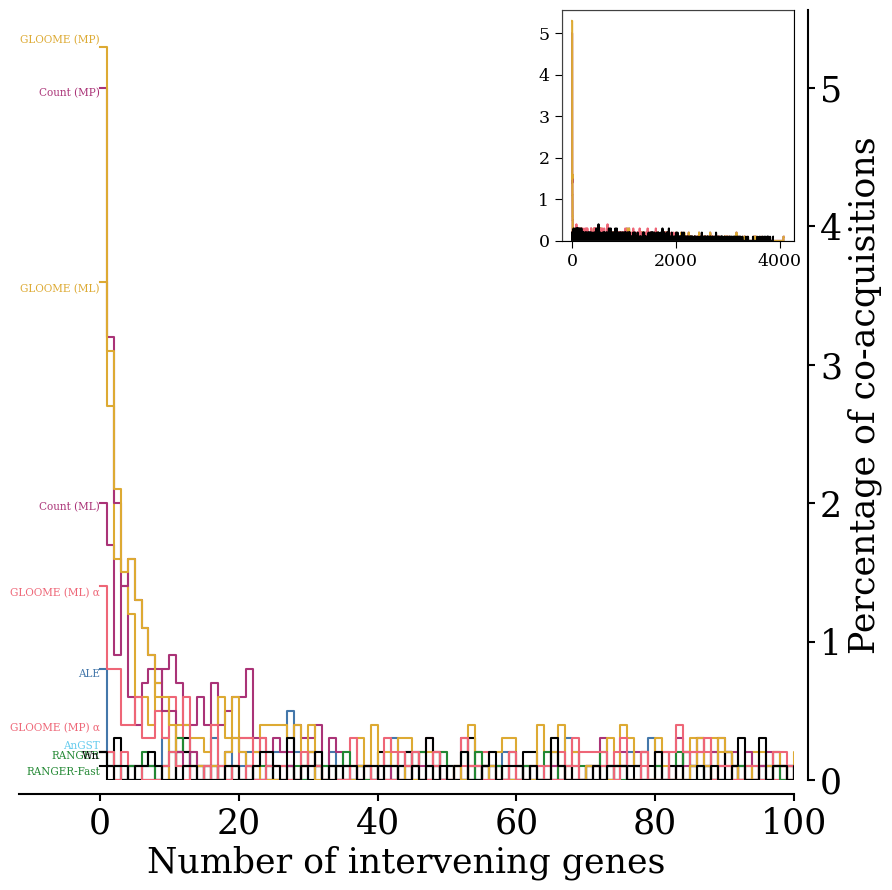

Method: ale, num_coacq: 10000.0, first bin y: 0.6
Method: angst, num_coacq: 10000.0, first bin y: 0.38999999999999996
Method: count.ml, num_coacq: 10000.0, first bin y: 0.5499999999999999
Method: gloome.ml, num_coacq: 10000.0, first bin y: 1.95
Method: gloome.ml.without_tree, num_coacq: 10000.0, first bin y: 0.8200000000000001
Method: ranger, num_coacq: 10000.0, first bin y: 0.42
Method: ranger-fast, num_coacq: 10000.0, first bin y: 0.22999999999999998
Method: count.mp, num_coacq: 10000.0, first bin y: 2.4350294824197425
Method: gloome.mp, num_coacq: 10000.0, first bin y: 2.4350294824197425
Method: gloome.mp.without_tree, num_coacq: 10000.0, first bin y: 1.35
Method: wn, num_coacq: 10000.0, first bin y: 0.36


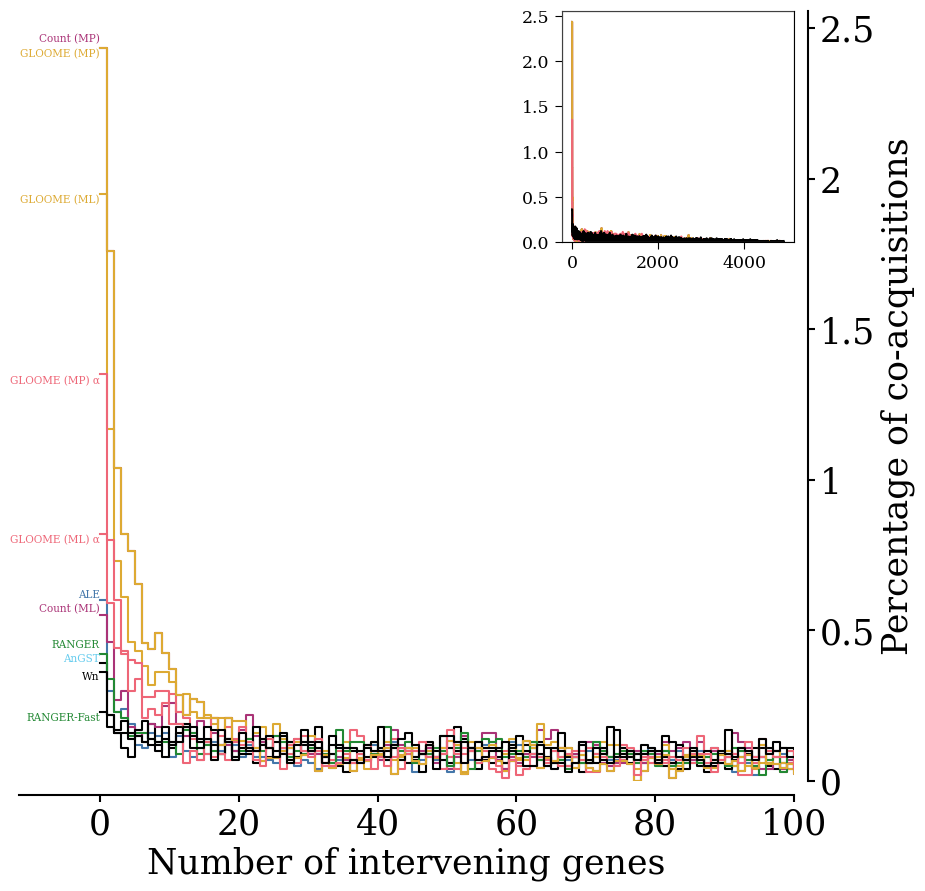

Method: ale, num_coacq: 100000.0, first bin y: 0.316
Method: angst, num_coacq: 100000.0, first bin y: 0.293
Method: count.ml, num_coacq: 100000.0, first bin y: 0.8920000000000001
Method: gloome.ml, num_coacq: 100000.0, first bin y: 0.947
Method: gloome.ml.without_tree, num_coacq: 100000.0, first bin y: 0.5479999999999999
Method: ranger, num_coacq: 100000.0, first bin y: 0.338
Method: ranger-fast, num_coacq: 100000.0, first bin y: 0.293
Method: count.mp, num_coacq: 100000.0, first bin y: 0.712
Method: gloome.mp, num_coacq: 100000.0, first bin y: 0.7100000000000001
Method: gloome.mp.without_tree, num_coacq: 100000.0, first bin y: 1.160097692437258
Method: wn, num_coacq: 100000.0, first bin y: 0.174


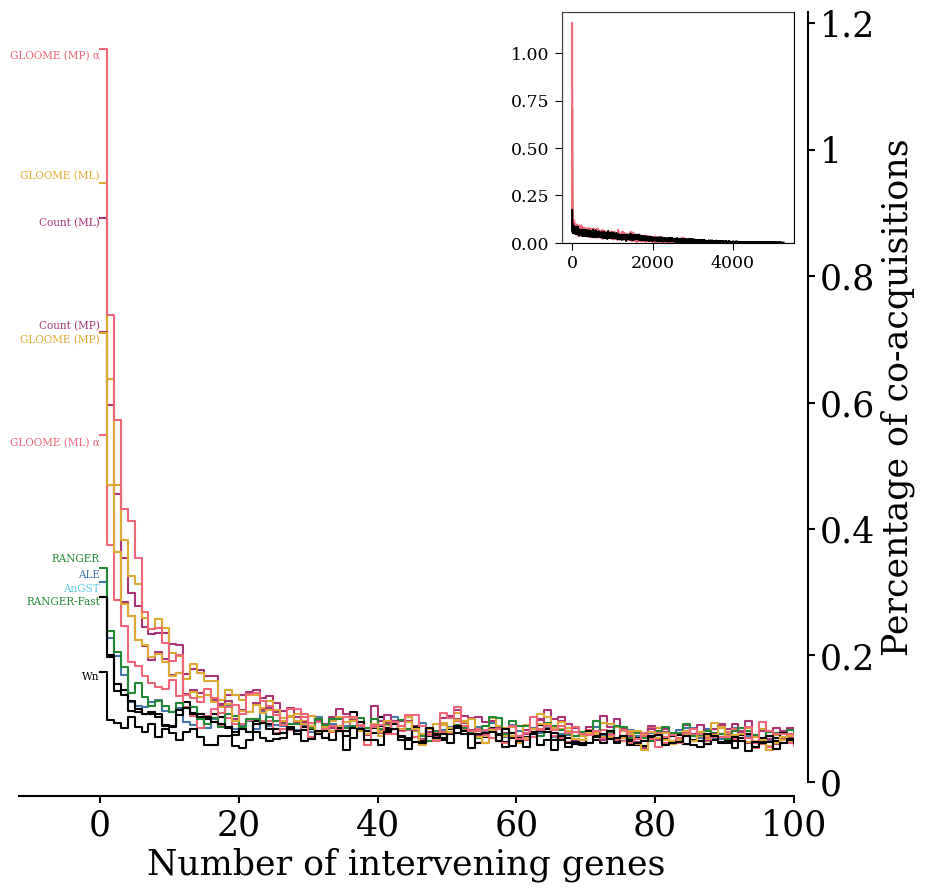

In [14]:
# for each method's df,
## retain only coacquisitions with known positions (`cq_df = cq_df[cq_df["notes"] == "gene_positions_are_available"]`)
## sort descending by the minimum of columns: nog1_transfers and nog2_transfers
## keep only the top 1e3, 1e4, 1e5 rows
### for each of these cases, plot the distribution of col: num_genes_between as a KDE
## save the plot as a jpg file

from adjustText import adjust_text

annotation_scale = 0.3
for i, num_coacq in enumerate([1e3, 1e4, 1e5]):
    fig, ax = plt.subplots(figsize=(10, 10))
    # set up inset axes for the full figure but in the main plot only show until right_x_lim
    right_x_lim = 100
    axins = ax.inset_axes([0.7, 0.7, 0.3, 0.3])
    # x and y limits for the inset won't be set
    annotations_texts = []
    for method in sorted(list(automatic_stringency_coacq_dfs.keys())):
        if method in manual_stringency_dict:
            # skip the methods that are already in the manual stringency dict
            continue
        # load the data
        cq_df = automatic_stringency_coacq_dfs[method]
        # keep only coacquisitions with known positions
        cq_df = cq_df[cq_df["notes"] == "gene_positions_are_available"]
        # sort by the minimum of nog1_transfers and nog2_transfers
        cq_df.loc[:, "min_transfers"] = cq_df[["nog1_transfers", "nog2_transfers"]].min(
            axis=1
        )
        # sort by min_transfers
        cq_df = cq_df.sort_values("min_transfers", ascending=False)

        # keep only the top num_coacq rows
        cq_df_num = cq_df.head(int(num_coacq))
        # plot the distribution of num_genes_between
        sns.histplot(
            cq_df_num["num_genes_between"],
            ax=ax,
            stat="percent",
            #  kde=True,
            element="step",
            fill=False,
            # binwidth of 1
            binwidth=1,
            color=marker_styles_dict[method]["marker_color"],
            label=marker_styles_dict[method]["label"],
            # log_scale=True,
        )
        # get the y for the first bin by using np.histogram with same binning
        # get the histogram data
        counts, bin_edges = np.histogram(
            cq_df_num["num_genes_between"],
            bins=np.arange(0, right_x_lim + 1, 1),
            density=False,
        )
        y_percentages = counts / len(cq_df_num) * 100
        first_bin_y = y_percentages[0]
        print(
            f"Method: {method}, num_coacq: {num_coacq}, first bin y: {first_bin_y}"
        )
        # add the annotation text
        annot = ax.annotate(
            marker_styles_dict[method]["label"],
            xy=(-0.05, first_bin_y),  # -0.05 is just left of the axes
            xycoords="data",
            ha="right",
            va="center",
            color=marker_styles_dict[method]["face_color"] if marker_styles_dict[method]["face_color"]!="white" else marker_styles_dict[method]["marker_color"],
            fontsize=annotation_scale * plt.rcParams["font.size"],
        )
        annotations_texts.append(annot)

        # # plot a y-line in the main plot: This seems incorrect
        # ## which shows expectation as average genome size
        # # get the genome sizes
        # genome_sizes = cq_df["contig:genome_size"].unique()
        # genome_sizes = [int(x.split(":")[1]) for x in genome_sizes]
        # # calculate the average of 1/genome_size
        # avg_genome_size_inverse = float(np.mean([1 / x for x in genome_sizes]))
        # # plot a y-line in the main plot
        # ax.axhline(
        #     y=avg_genome_size_inverse,
        #     color=marker_styles_dict[method]["marker_color"],
        #     linestyle="--",
        #     linewidth=1,
        # )

    for method in sorted(list(manual_threshold_coacq_dfs.keys())):
        # load the data based on stringency level index matching num_coacq index
        stringency_level = manual_stringency_dict[method.replace('.', '_', 1)][i]
        cq_df = manual_threshold_coacq_dfs[method][stringency_level]
        # keep only coacquisitions with known positions
        cq_df = cq_df[cq_df["notes"] == "gene_positions_are_available"]
        # sort by the minimum of nog1_transfers and nog2_transfers
        cq_df = cq_df.sort_values('min_transfers', ascending=False)
        # keep only the top num_coacq rows
        cq_df_num = cq_df.head(int(num_coacq))
        # plot the distribution of num_genes_between
        sns.histplot(cq_df_num['num_genes_between'], ax=ax,
                     stat='percent',
                    #  kde=True,
                    element='step', fill=False,
                    # binwidth of 1
                    binwidth=1,
                    color=marker_styles_dict[method]['marker_color'],
                    # log_scale=True,
                    )
        # plot the same data in the inset
        sns.histplot(cq_df_num['num_genes_between'], ax=axins,
                     stat='percent',
                    #  kde=True,
                    element='step', fill=False,
                    # binwidth of 1
                    binwidth=1,
                    color=marker_styles_dict[method]['marker_color'],
                    # log_scale=True,
                    )
        # get the y for the first bin by using np.histogram with same binning
        # get the histogram data
        counts, bin_edges = np.histogram(
            cq_df_num["num_genes_between"],
            bins=np.arange(0, right_x_lim + 1, 1),
            density=False,
        )
        y_percentages = counts / len(cq_df_num) * 100
        first_bin_y = y_percentages[0]
        print(
            f"Method: {method}, num_coacq: {num_coacq}, first bin y: {first_bin_y}"
        )
        annot = ax.annotate(
            marker_styles_dict[method]["label"],
            xy=(-0.05, first_bin_y),  # -0.05 is just left of the axes
            xycoords="data",
            ha="right",
            va="center",
            color=marker_styles_dict[method]["face_color"] if marker_styles_dict[method]["face_color"]!="white" else marker_styles_dict[method]["marker_color"],
            fontsize=annotation_scale * plt.rcParams["font.size"],
        )
        annotations_texts.append(annot)

        # # plot a y-line in the main plot: This seems incorrect
        # x = np.linspace(1, right_x_lim, 10000)
        # y = 1 / x
        # ax.plot(x, y, color='black', linestyle='--', linewidth=1)

    # indicate the inset zoom
    axins.indicate_inset_zoom(axins)

    right_x_lim = 100
    # set xlim to 0 to right_x_lim
    ax.set_xlim(0, right_x_lim)

    # set the x and y axis labels
    ax.set_xlabel("Number of intervening genes")
    axins.set_xlabel("")
    ax.set_ylabel("Percentage of co-acquisitions")
    axins.set_ylabel("")
    # move the ax y-axis to the right
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    # adjust annotations to not overlap
    adjust_text(
        annotations_texts,
        only_move={'text': 'y'},
        expand_axes=True
    )
    # # explicitly set all the annotation x=0 right aligned
    for annot in annotations_texts:
        annot.set_x(0)
        annot.set_ha("right")
        # set the xy to be 0.5 points to the right
        annot.xy = (0, annot.xy[1])

    # Tufte style
    # remove top and left spines
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    # set the bottom and right spines to be thicker
    ax.spines["bottom"].set_linewidth(1.5)
    ax.spines["right"].set_linewidth(1.5)
    # set the ticks to be thicker
    ax.tick_params(axis="both", which="major", width=1.5)
    ax.tick_params(axis="both", which="minor", width=1.5)
    # set spine limits to be the same as the data limits
    max_auto_stringency = max(
        [
            automatic_stringency_coacq_dfs[method]["num_genes_between"].max()
            for method in automatic_stringency_coacq_dfs.keys()
        ]
    )
    max_manual_stringency = max(
        [
            manual_threshold_coacq_dfs[method][stringency_level]["num_genes_between"].max()
            for method in manual_threshold_coacq_dfs.keys()
            for stringency_level in manual_threshold_coacq_dfs[method].keys()
        ]
    )
    # set the y limits to be the same as the data limits
    y_data_lims = 0, max(max_auto_stringency, max_manual_stringency)

    # add tick and tick label for the spine limits if they are not already there
    # get the tick locations
    y_ticks = ax.get_yticks()
    # add the tick labels for the spine limits
    # add the tick labels for the y axis
    if y_data_lims[0] not in y_ticks:
        ax.yaxis.set_major_locator(FixedLocator(list(y_ticks) + [y_data_lims[0]]))
        ax.yaxis.set_major_formatter(
            mpl.ticker.FuncFormatter(
                lambda x, pos: (
                    f"{x:.2f}".rstrip("0").rstrip(".") if x % 1 != 0 else f"{int(x)}"
                )
            )
        )
    if y_data_lims[1] not in y_ticks:
        ax.yaxis.set_major_locator(FixedLocator(list(y_ticks) + [y_data_lims[1]]))
        ax.yaxis.set_major_formatter(
            mpl.ticker.FuncFormatter(
                lambda x, pos: (
                    f"{x:.2f}".rstrip("0").rstrip(".") if x % 1 != 0 else f"{int(x)}"
                )
            )
        )

    # let axes breathe by moving the spines away from the data
    ax.spines["right"].set_position(("outward", 10))
    ax.spines["bottom"].set_position(("outward", 10))

    # halve the font size of the ticks in axins
    axins.tick_params(axis="both", which="major", labelsize=0.5 * mpl.rcParams["font.size"])

    # save as jpg dpi=300
    fig.savefig(
        os.path.join(
            plots_dir,
            f"distribution_of_distances_between_coacquired_genes_{str(num_coacq)}.jpg",
        ),
        format="jpg",
        bbox_inches="tight",
        dpi=300,
    )
    plt.show()